# PGR-TK experiments

Adapted code from [github.com/GeneDx/pgr-tk-notebooks](https://github.com/GeneDx/pgr-tk-notebooks/tree/main)

In [2]:
from pathlib import Path
import pgrtk, os
print(pgrtk.__version__)

import matplotlib.pyplot as plt
from IPython.display import SVG

pgrtk 0.3.6 (bioconda release build, linux [x86_64] [rustc 1.69.0 (84c898d65 2023-04-16)])


## Index the HPRC assemblies 

In [ ]:
%%bash

# for debugging
export RUST_BACKTRACE=1

# index the assemblies (takes ~1 hr)
pgr-mdb <(echo data/HPRC-yr1.agc) data/HPRC-yr1

## Define helper function

In [16]:
def get_seq_list(sdb: pgrtk.SeqIndexDB, ROI_seq: list, ROI_len: int, padding: int=1.5e5, plot=True):
    '''
    Get a list of sequences from sdb index that match the ROI_seq.
    :param sdb: SeqIndexDB object, the PGR index
    :param ROI_seq: ROI sequence
    :param ROI_len: ROI length
    :param padding: padding length   
    '''

    # query the PGR index to find matches of this ROI
    query_results = pgrtk.query_sdb(sdb, ROI_seq, merge_range_tol=100000)

    seq_list = []
    seq_info = sdb.seq_info.copy() # Cache seq_info to reduce Rust HashMap to Python dictionary conversion in a loop
    i = 1
    if plot:
        plt.figure(figsize=(36, 36))
    for k in list(query_results.keys()):
        ctg_name, source, _ = seq_info[k]
        seq_id = k
        rgns = query_results[k].copy()

        # rgns = pgrtk.merge_regions(rgns,tol=1000) # if additional region merge needed

        for rgn in rgns:
            b, e, length, orientation, aln = rgn
            aln.sort()
            #print(aln[0][0][0], aln[-1][0][1])
            if aln[0][0][0] > padding or aln[-1][0][1] < padding + ROI_len:
                continue
            
            seq =  sdb.get_sub_seq(source, ctg_name, b, e)
            # print(source, ctg_name, b, e)
            if orientation == 1:
                seq = pgrtk.rc_byte_seq(seq)

            seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
            
            if e-b < len(ROI_seq) * 0.75: # ignore partial match
                continue
            else:
                x, y = pgrtk.get_shmmr_dots(ROI_seq, seq, 32, 32, 1, 1)
                if i <= 25 and plot:
                    plt.subplot(5,5,i)
                    plt.plot(x, y, ".", markersize=0.1)
                    ylabel = "#".join(ctg_name.split("#")[:2])
                    if len(ylabel) > 20:
                        ylabel = ylabel[:20]
                    plt.ylabel(ylabel)
                    # plt.plot([padding, padding],[0, max(y)], "r")
                    # plt.plot([padding+ROI_len, padding+ROI_len],[0, max(y)], "r")
                i += 1

    return seq_list

## View some regions

In [4]:
# load index into memory (takes ~1 min)
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("data/HPRC-yr1")

### RH locus

- GRCh38.chr1:25240000-25460000
- CHM13.chr1:25076257-25296359

Text(0, 0.5, 'RH')

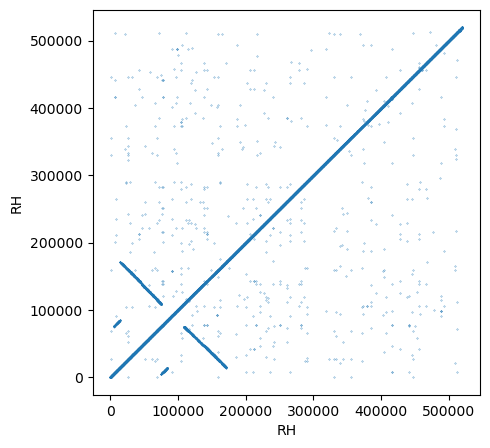

In [5]:
# grab RH region from CHM13Y assembly
ref_file_name, ROI_chr, ROI_b, ROI_e = 'CHM13Y', 'chr1', 25240000, 25460000
padding = 150000
ROI_len = ROI_b - ROI_e
ROI_seq = sdb.get_sub_seq(ref_file_name, ROI_chr, ROI_b-padding, ROI_e+padding)

# view a dotplot of this region to see repeat structure
x, y = pgrtk.get_shmmr_dots(ROI_seq, ROI_seq, 32, 32, 2, 2)
plt.figure(figsize=(5,5))
plt.plot(x, y, ".", markersize=0.5)
plt.xlabel("RH")
plt.ylabel("RH")

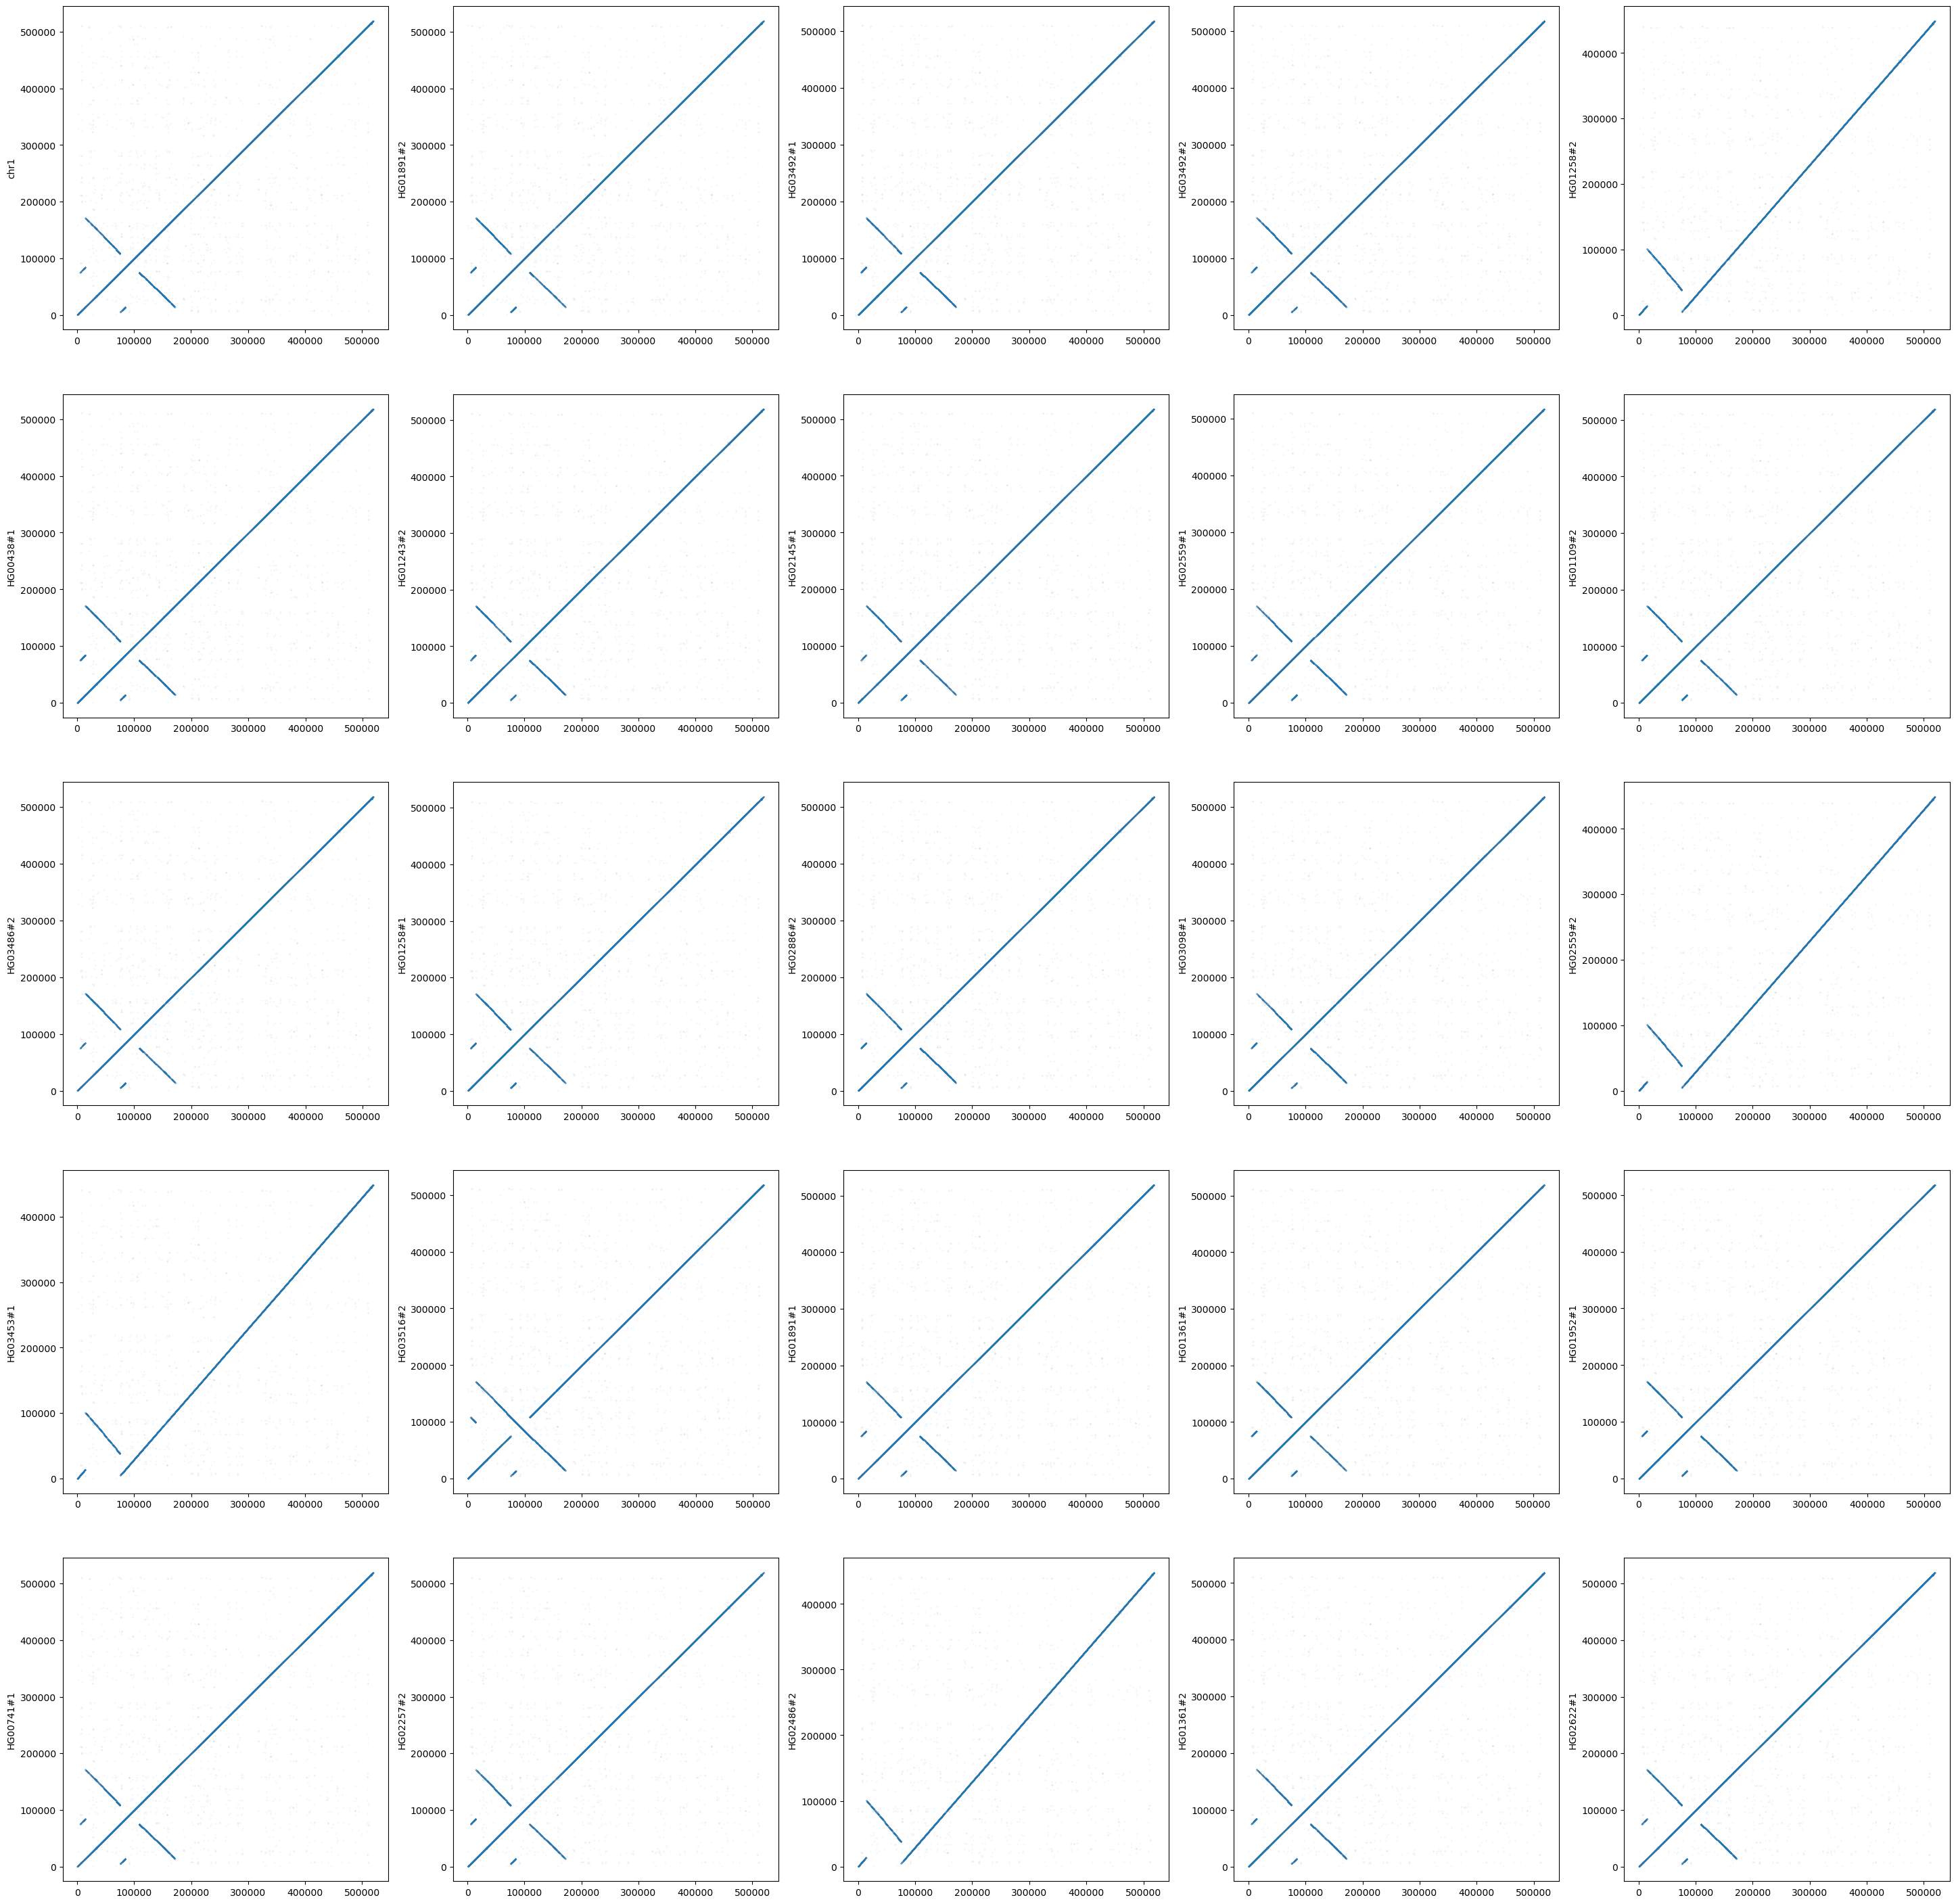

In [17]:
# get matches in the PGR index
seq_list = get_seq_list(sdb, ROI_seq, ROI_len, padding, plot=True)

In [18]:
# create graph and save
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=2, min_span=28)

new_sdb.generate_mapg_gfa(0, "data/RH.gfa")
new_sdb.write_midx_to_text_file("data/RH.midx")

In [19]:
%%bash

Bandage image data/RH.gfa figures/RH_bandage.png --edgewidth 12.0 --edgecol blue --colour random --outline 20.0 

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/iblm/netapp/data4/mcuoco/tmp/runtime-mcuoco'


![RH locus](figures/RH_bandage.png)

### Huntington's disease locus

- GRCh38.chr4:3066364-3083563 
- CHM13.chr4:3065090-3082318

Text(0, 0.5, "Huntington's")

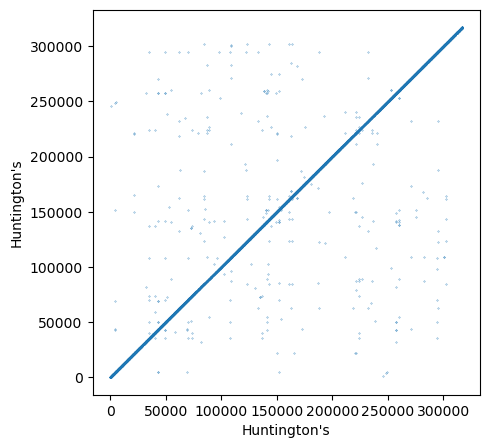

In [20]:
# grab RH region from CHM13Y assembly
ref_file_name, ROI_chr, ROI_b, ROI_e = 'CHM13Y', 'chr4', 3065090, 3082318
padding = 150000
ROI_len = ROI_b - ROI_e
ROI_seq = sdb.get_sub_seq(ref_file_name, ROI_chr, ROI_b-padding, ROI_e+padding)

# view a dotplot of this region to see repeat structure
x, y = pgrtk.get_shmmr_dots(ROI_seq, ROI_seq, 32, 32, 2, 2)
plt.figure(figsize=(5,5))
plt.plot(x, y, ".", markersize=0.5)
plt.xlabel("Huntington's")
plt.ylabel("Huntington's")

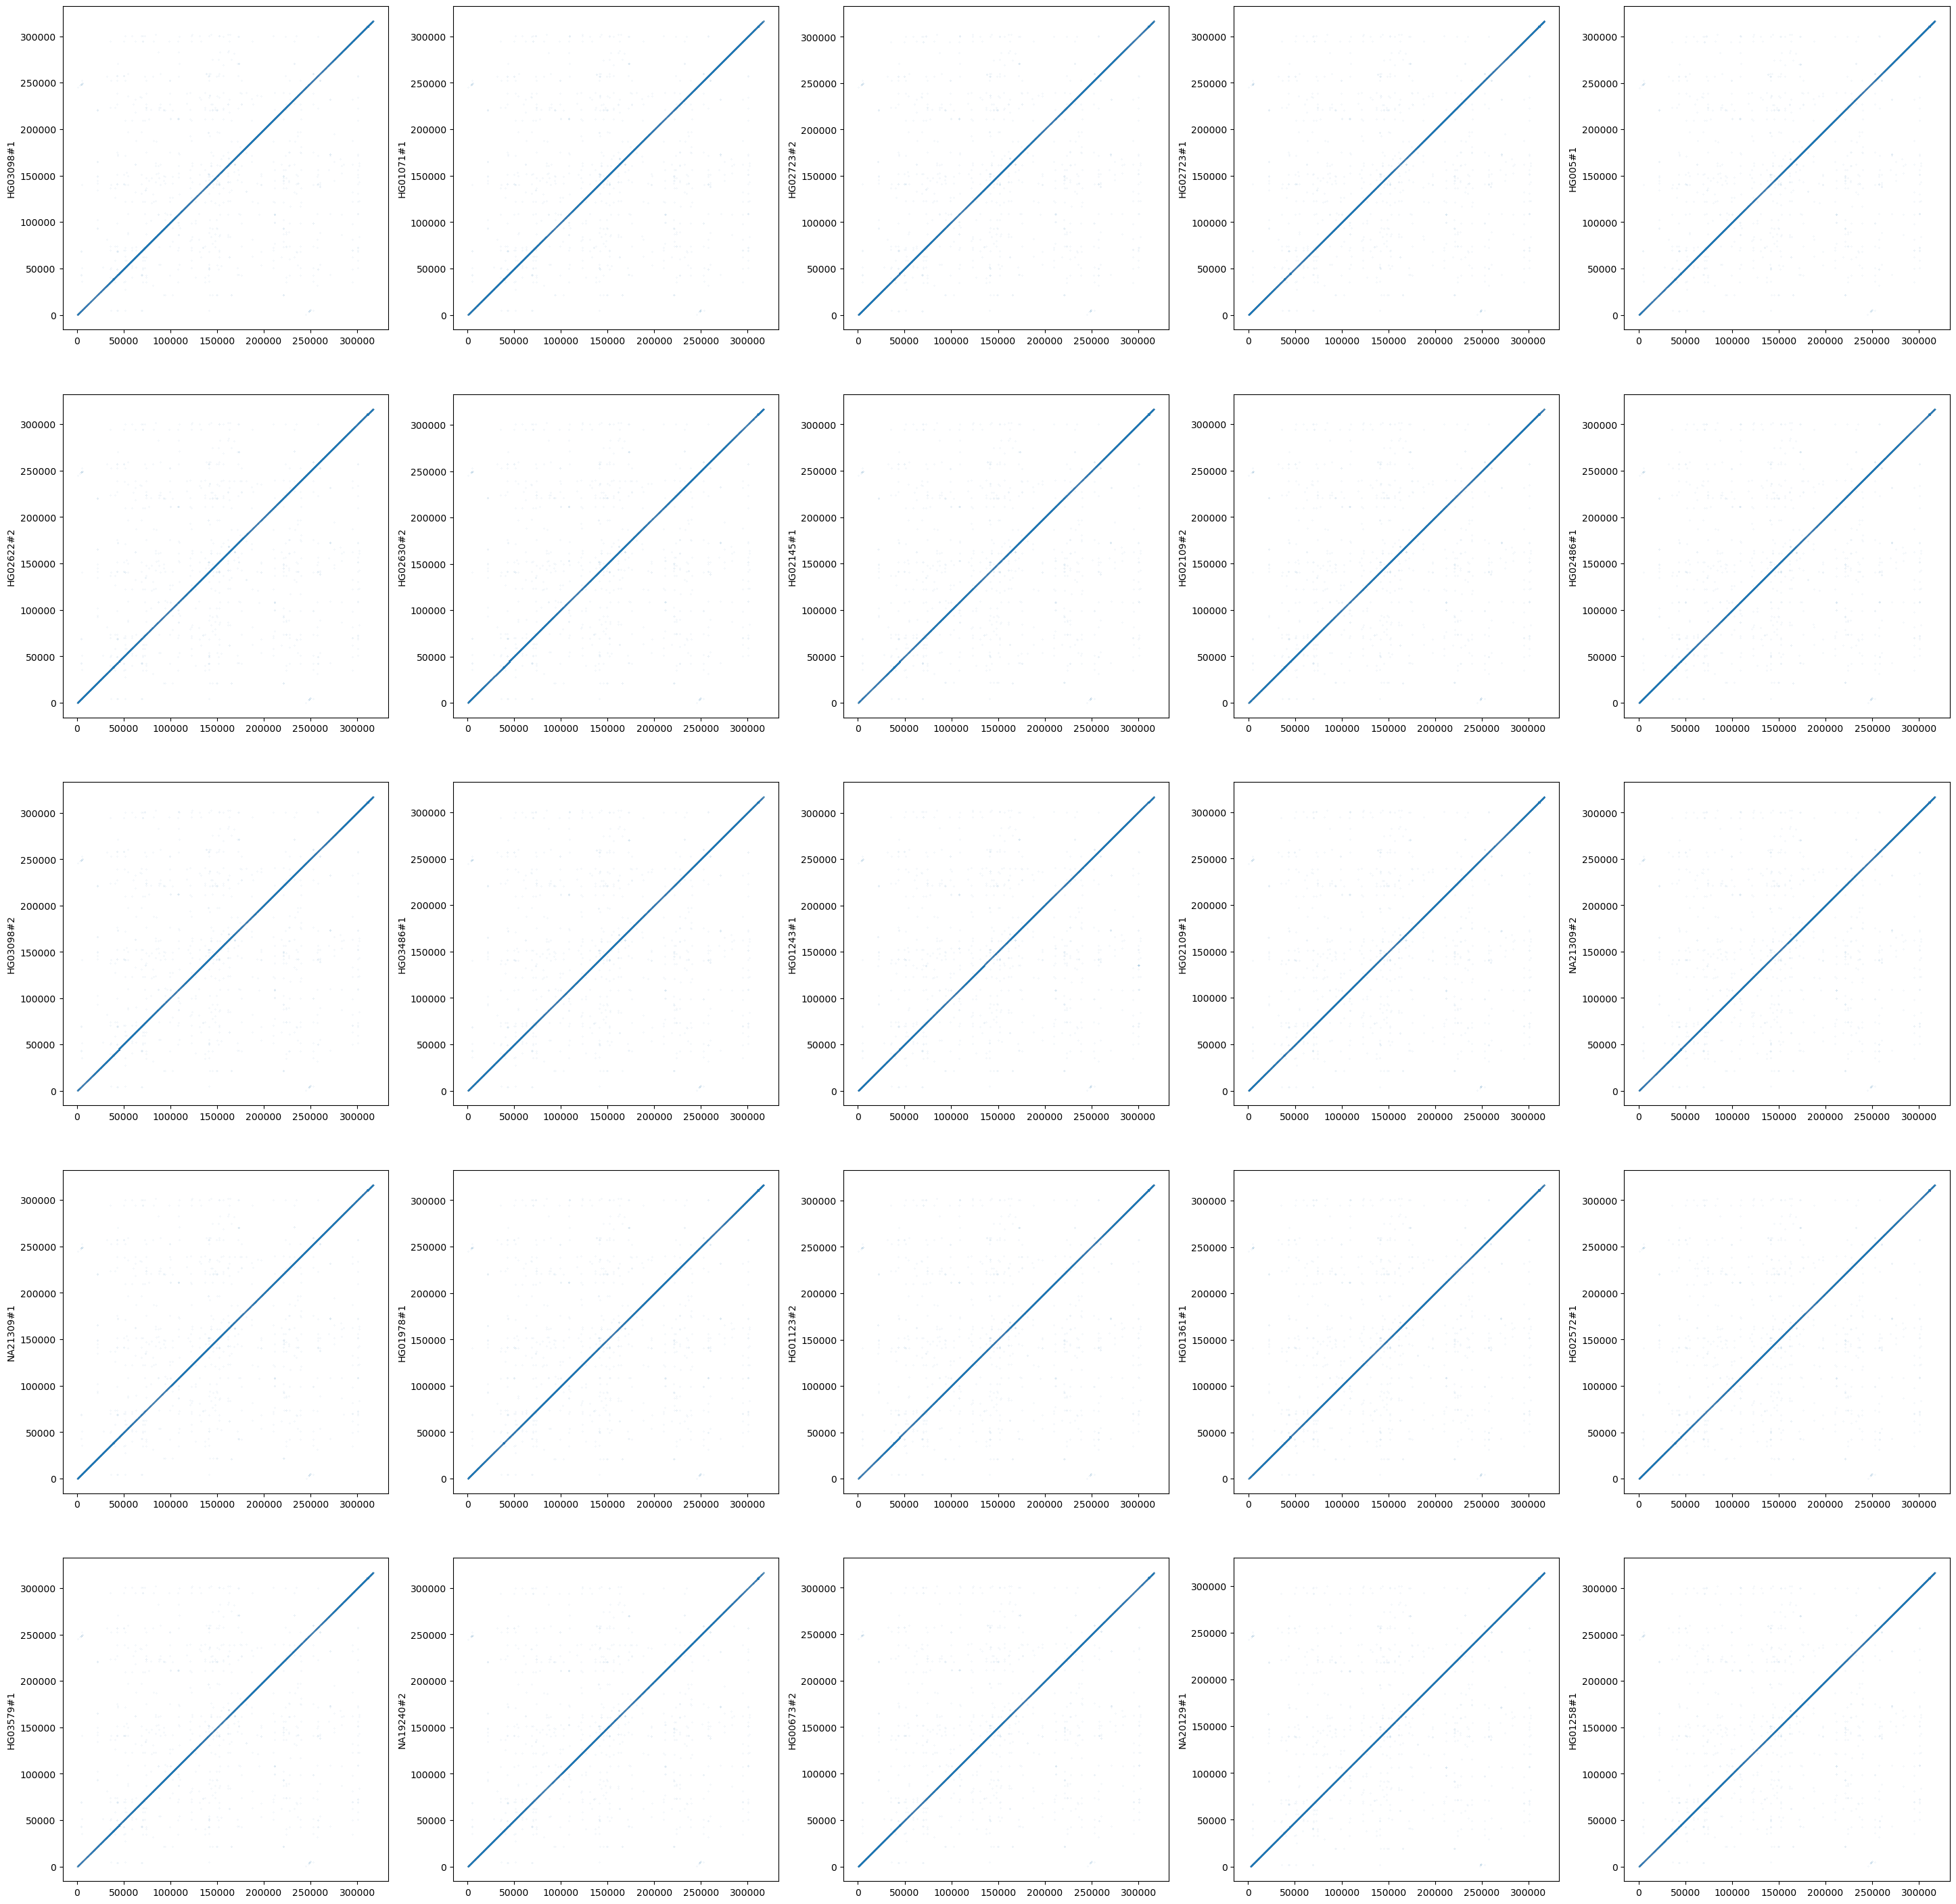

In [21]:
# get matches in the PGR index
seq_list = get_seq_list(sdb, ROI_seq, ROI_len, padding, plot=True)

In [22]:
# create graph and save
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=2, min_span=28)

new_sdb.generate_mapg_gfa(0, "data/Huntingtons.gfa")
new_sdb.write_midx_to_text_file("data/Huntingtons.midx")

In [23]:
%%bash

Bandage image data/Huntingtons.gfa figures/Huntingtons_bandage.png --edgewidth 12.0 --edgecol blue --colour random --outline 20.0 

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/iblm/netapp/data4/mcuoco/tmp/runtime-mcuoco'


![Huntingtons locus](figures/Huntingtons_bandage.png)